<a href="https://colab.research.google.com/github/ritikpathania/fraud_detection_banking/blob/main/fraud_detection_banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sdv xgboost scikit-learn pandas -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.9/185.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.5 MB/s eta 0:00:00


In [25]:
import pandas as pd
import xgboost as xgb
import joblib
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


In [26]:
print("\nGenerating synthetic data...")
metadata = SingleTableMetadata()
metadata.add_column(column_name='transaction_id', sdtype='id')
metadata.add_column(column_name='account', sdtype='id')
metadata.add_column(column_name='amount', sdtype='numerical', computer_representation='Float')
metadata.add_column(column_name='currency', sdtype='categorical')
metadata.add_column(column_name='timestamp', sdtype='datetime', datetime_format='%Y-%m-%d %H:%M:%S')
metadata.add_column(column_name='is_fraud', sdtype='boolean')
synthesizer = GaussianCopulaSynthesizer(metadata)
sample_data = pd.DataFrame({
    'transaction_id': [1, 2, 3, 4], 'account': ['acc_1', 'acc_2', 'acc_1', 'acc_3'],
    'amount': [100.50, 25.00, 5000.00, 150.75], 'currency': ['USD', 'EUR', 'USD', 'GBP'],
    'timestamp': pd.to_datetime(['2023-01-01 12:00', '2023-01-01 13:00', '2023-01-02 08:00', '2023-01-02 09:00']),
    'is_fraud': [False, False, True, False]
})
synthesizer.fit(sample_data)
synthetic_data = synthesizer.sample(num_rows=20000)
print(f"Successfully generated {len(synthetic_data)} synthetic transactions.")


Generating synthetic data...
Successfully generated 20000 synthetic transactions.


In [27]:
print("\nPerforming feature engineering and preprocessing...")
synthetic_data = synthetic_data.sort_values(['account', 'timestamp'])
synthetic_data['hour_of_day'] = synthetic_data['timestamp'].dt.hour
synthetic_data['day_of_week'] = synthetic_data['timestamp'].dt.dayofweek
synthetic_data['avg_amount_per_account'] = synthetic_data.groupby('account')['amount'].transform('mean')
synthetic_data['amount_deviation'] = synthetic_data['amount'] - synthetic_data['avg_amount_per_account']
synthetic_data['time_since_last_txn'] = synthetic_data.groupby('account')['timestamp'].diff().dt.total_seconds().fillna(0)
features = ['amount', 'currency', 'hour_of_day', 'day_of_week', 'avg_amount_per_account', 'amount_deviation', 'time_since_last_txn']
target = 'is_fraud'
X = synthetic_data[features]
y = synthetic_data[target]
categorical_features = ['currency']
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data preparation complete.")


Performing feature engineering and preprocessing...
Data preparation complete.


In [28]:
print("\nTraining and tuning the model...")
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, scale_pos_weight=scale_pos_weight))
])
param_grid = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [3, 5, 7], 'classifier__learning_rate': [0.1, 0.2]}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=0, scoring='f1')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Model training complete.")
print("Best parameters found: ", grid_search.best_params_)


Training and tuning the model...
Model training complete.
Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}



Performing final evaluation and threshold analysis...


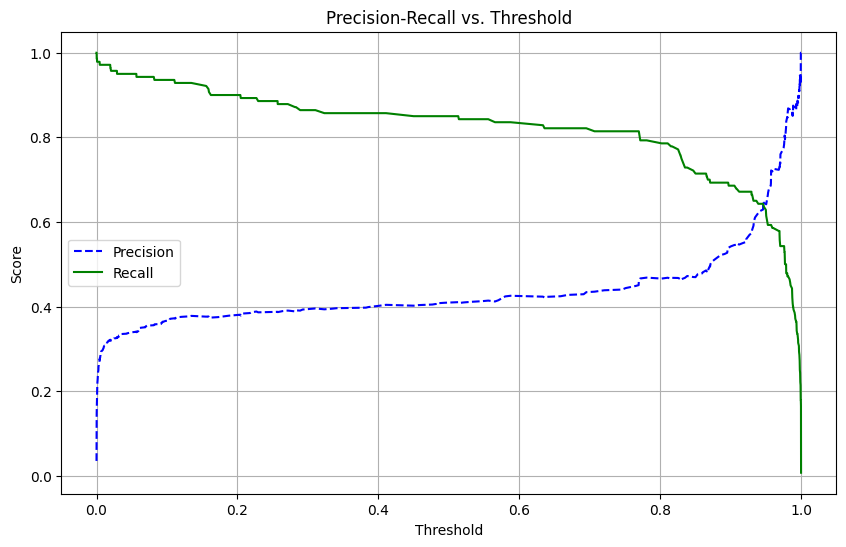


Default threshold (0.5) Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.97      3860
        True       0.41      0.85      0.55       140

    accuracy                           0.95      4000
   macro avg       0.70      0.90      0.76      4000
weighted avg       0.97      0.95      0.96      4000


Optimal Threshold found at: 0.9462
Classification Report using the Optimal Threshold:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3860
        True       0.65      0.64      0.65       140

    accuracy                           0.98      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.98      0.98      0.98      4000



In [29]:
print("\nPerforming final evaluation and threshold analysis...")

# Get the predicted probabilities for the positive class (fraud)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.title('Precision-Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold that gives the best balance (where precision and recall cross)
intersection_idx = (precision >= recall).tolist().index(True)
best_threshold = thresholds[intersection_idx]

print(f"\nDefault threshold (0.5) Classification Report:")
y_pred_default = (y_probs >= 0.5).astype(int)
print(classification_report(y_test, y_pred_default))

print(f"\nOptimal Threshold found at: {best_threshold:.4f}")
print(f"Classification Report using the Optimal Threshold:")
y_pred_optimal = (y_probs >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_optimal))

In [31]:
print("\nSaving the final model and preprocessor...")
joblib.dump(best_model.named_steps['classifier'], 'xgboost_model.pkl')
joblib.dump(best_model.named_steps['preprocessor'], 'preprocessor.pkl')
print("\nAll steps complete. Please download the new '.pkl' files.")


Saving the final model and preprocessor...

All steps complete. Please download the new '.pkl' files.
